# Neural Networks Programming Project 1
The following project is dedicated to the two dry erase markers (blue and black) that lost their lives to my fixation on mathematically deriving each step of forward and backpropogation. Also I dedicate this work to the many lines of code that were written and later thrown out along the way.

### Goal:
Design a simple ANN for learning signals corrupted by noise. 

For demonstration, the following signals will be modeled 
### (a) $f_1(x) = x^4 - 22x^2$
### (b) $f_2(x,y) = x^4 - 22x^2 - y^4 + 22y^2$

where the model will be trained, validated, and tested on 
1. function <b>(a)</b> without noise. 
2. function <b>(b)</b> without noise. 
3. function <b>(a)</b> with samples generated by $Z_k = f_1(X_k) + \epsilon$, where $\epsilon \sim \mathcal{N}(\mu = 0, \sigma = 20)$
4. function <b>(b)</b> with samples generated by $Z_k = f_1(X_k) + \epsilon$, where $\epsilon \sim \mathcal{N}(\mu = 0, \sigma = 50)$



##### 2. List the choices that need to be made when designing an ANN learning system that have already been made for you in this assignment.
* determine an objective function $f$
* decide how many inputs $N$ are associated with $f$ ($N=2$)
* determin on what interval the objective function is valid 
* select an optimization/learning approach/learning rule for adjusting weights during training


##### 3. For each of these choices, list which option professor chooses in making this assignment.
* we have two objective functions $f_1(x) = x^4 - 22x^2$ and $f_2(x,y) = x^4 - 22x^2 - y^4 + 22y^2$)
* decide how many inputs $N$ are associated with the target ($N = 2$)
* the first objective function is defined on $[-5, 5]$, and the second objective function is defined on $[-5, 5]^2$
* decide a particular optimization/learning approach/learning rule (supervised learning via error backpropagation)


##### 4. List the choices you need to make regarding the design of your ANN
* for a signal-plus-noise model $Z = f(X, Y) + \epsilon$, decide what assumptions can be made, if any, about the noise and outliers
* define a loss function $L$ penalizing deviations from $f$
* decide a learning rate to initialize $\eta$
* decide how many layers hidden layers $H$ are necessary to capture features
* decide how many hidden units $H_n$ are required for the $n$'th hidden layer
* decide if artificial neurons will consist of summation units or product units or a mixture
* determine how prior weights and biases between AN will be initialized
* use domain knowledge to select non-linear activation functions that also work as desired with the training method
* decide an appropriate number of samples to be used for training, validation, and test sets
* decide how epochs should be organized and how many to execute before training stops
* decide any other indications of overfitting that suggests training should stop

##### 5/7. Choose an option that seems reasonable to you for each of these design choices and explain why it seems reasonable to you.

* because no prior information is known about the system, we follow the principle of maximum entropy and assume that the noise is Gaussian $\epsilon \sim^{iid} \mathcal{N}(\mu = 0, \sigma = c)$, since the family of exponential distributions are easy to work with using Baye's theorem.
* for a signal-plus-noise model $Z = f(X, Y) + \epsilon$, this project will compare two loss functions for approximating $f_1$ and $f_2$:
    - $L_1(\hat f) = \sum \{Z - \hat f(x,y)\}^2$ for penalizing large values 
    - $L_2(\hat f) = \sum \{Z - \hat f(x,y)\}^2$ because we expect a large variance
* let $\eta = 0.01$
* we will create a network with $H = 2$ hidden layers for not much rhyme or reason
* we will use $h_1 = h_2 = 4$ for not much rhyme or reason
* artificial neurons will be summation units because this is what I am most familiar with (I am not sure why this is preferred over product units)
* prior weights will be assigned randomly because I have no prior knowledge about how weights can approximate the objective function. all biases $b$ will be initialized to 1, since $b \ne 0$ allows the backpropogation algorithm to adjust biases for a value that optimizes the given objective function
* the ReLU function will be used for its easy differentiability (required for backprop) and because any linear combination of ReLU functions will result in piecewise linear outputs, and this will make it easier to graphically visualize weights



## ANN Implementation
This section will test and demonstrate how to build an ANN from scratch. Precisely, the defined data structure will model a simple n-layer feed-forward artificial neural network consisting of summation units and arbitrary activation functions at each neuron and no skip connections.

All code and mathematics is shown step by step. 

### Constructing a Python Class: ANN
To keep things clean, we will start with a blank slate class called `ANN`. Gradually, each method will be motivated and added using the `setattr` built-in in Python, as demonstrated here

In [1]:
class Foo:
    def __init__(self, a):
        self.bar = a

f = Foo("bar")
        
def outside_method(self):
    print("foo bar = foo " + self.bar)
setattr(Foo, 'write_bar', outside_method)

f.write_bar()

foo bar = foo bar


all the following code was personally written and algorithms were deived without external resources. These followed from my understanding of ANNs from class, readings, and my self-study of "Pattern Recognition and Machine Learning" (Bishop, 2006).

#### A Blank Slate
Everyone knows that "Artificial Neural Network" is nothing more than a sexy way to say "dot products." Unfortunately, the latter terminology has exhausted its NSF funding. Let's hope nobody asks what numpy is doing.

In [2]:
from typing import List
import numpy as np

class ANN:
    pass

##### Useful Functions

Throw in tanh, Leaky ReLU, logistic sigmoid, for a non-linear activation function (this is interesting to me. ReLU is non-linear...except where it is linear on the domains $(-\infty, 0)$ and $(0, \infty)$... Maybe a piecewise linear transformation could be viewed as a proper linear transformation (after making some clever assumptions about the operations on the underlying vector spaces), implying that the resulting network is linear)

In [3]:
# Activation Function with derivatives
def tanh(x, ddx=False): 
    if ddx:
        return 1 - np.square(np.tanh(x))
    return np.tanh(x)

def leaky_ReLU(x, ddx=False):
    if ddx:
        return np.where(x > 0, 1, 0.01)
    return np.where(x > 0, x, x * 0.01)

def sigmoid(x, ddx=False):
    if ddx:
        return np.exp(-x) / np.square(1 + np.exp(-x))
    return 1 / (1 + np.exp(-x))


# Cost function with derivatives
def half_SSE(x, y, ddx=False):
    if ddx:
        return np.sum(np.subtract(x,y))
    return np.sum(np.square(np.subtract(x,y))) / 2


#### Creating the Network

Consider the following ANN
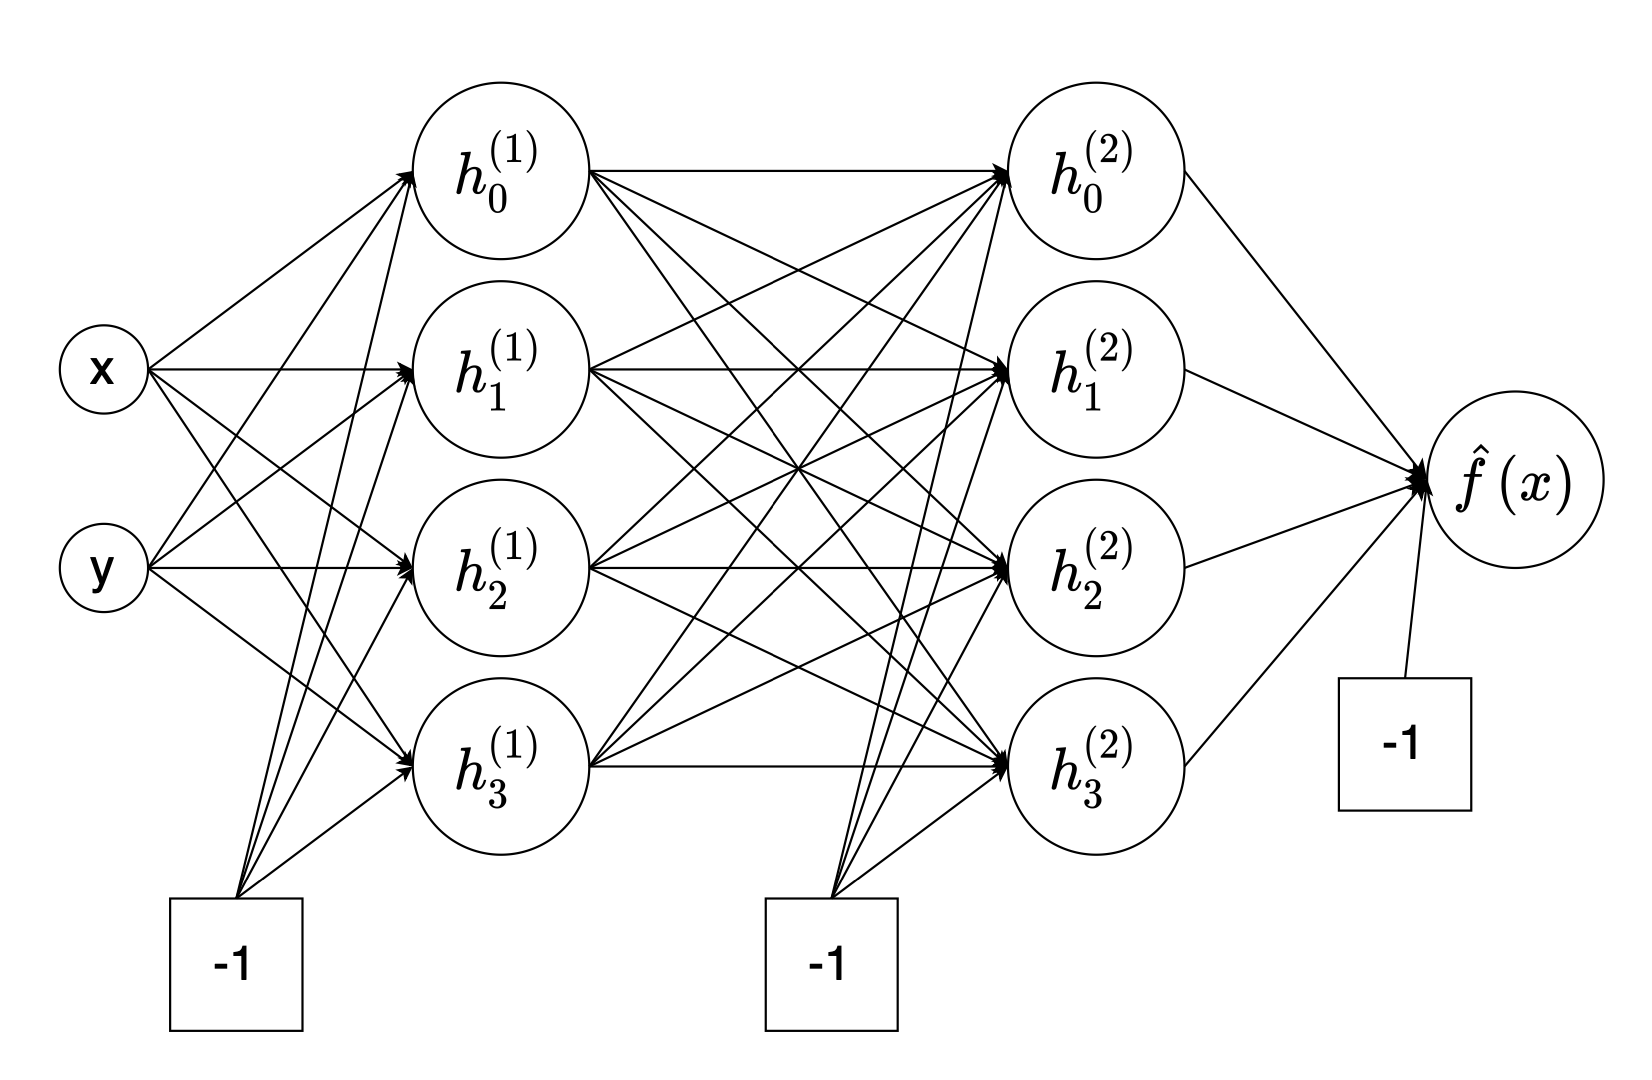

Notice its shape is characterized by the number of weights. By bundling weights between individual layers into a matrix, a constructor method can infer the topology of the artificial neurons. For instance, the weight matrix for the first layer of the above network have four rows (four outputs) and three columns (x, y, and bias). Since a multilayer network is nothing but several nested network. Therefore, a deep neural network can be characterized by a list of weight matrices.

Therefore, we can construct a Neural Network using only a list of starting weights, an activation function (or several), and a single cost function. Here is a constructor I made for this.

In [4]:
def __init__(self, weight_mat_list: List[float], activation: callable, cost: callable, bias = False):
    """Models a simple multi-layer feed-forward ANN with ReLU activation functions and no skip connections.

    weight_mat_list:
        * tuple or list of length 'n' of matrices (row-major) whose rows and columns determine neurons per layer and starting weights
        * weight_mat_list[0] connects the input layer to the first hidden layer
        * weight_mat_list[n-1] connects the last hidden layer to the output layer
        * in general, weight_mat_list[k] connects layer '(k)' to layer '(k+1)'
        * artificial neurons in each layer are 0-indexed
        * weight_mat_list[k][i][j] points away from neuron '(j)' in layer '(k)' and enters neuron '(i)' in layer '(k+1)'
        * unless 'bias' is set to true, the bias at each layer is automatically initialized to -1

    activation:
        a callable activation function, with and optional derivative flag

    cost:
        a callable cost function, with an optional derivative flag

    bias = False:
        when set to True, the user indicates that the last column of each weight matrix (in weight_mat_list) denotes the
        bias initializaed values. If bias is False, all bias terms are initialized to 1.

        * Note: for '(m)' artificial neurons, a matrix with '(m+1)' columns is required if the 'bias' is set to true. 
    """

    self.last_z = []                                # increases efficiency later (during backprop)
    self.last_a = []                                # increases efficiency later (during backprop)
    self.activation = activation                    # select an activation function for all ANs
    self.cost = cost                                # assign a cost function to network
    self.num_layers = len(weight_mat_list)          # count layers
    if not bias:  # then give each layer a bias weight 
        for layer in range(self.num_layers):
            summation_matix = weight_mat_list[layer]
            weight_mat_list[layer] = np.column_stack(
                    (
                    summation_matix,                       # initializing weights with passed weights
                    np.ones(np.shape(summation_matix)[0])  # initializing all biases to 1
                    ) 
                )
    self.weight_mat_list = weight_mat_list          # store summation matrices

    
setattr(ANN, '__init__', __init__)

#### Forward Propogation
Consider the last hidden layer in the above network with $N = 4$ artificial neurons. The units linearly combine together with a bias unit to form the output

$$
f_{NN}(x) = \sum^{N-1}_{n=0}(w^{(2)}_n h^{(2)}_n) + b
$$

Treating the bias term as another activation unit $h^{(2)}_4 = -1$, we get the following formula for propogating forward from the last layer.

$$
f_{NN}(x) = a(\sum^{N}_{n=1}w^{(2)}_n h^{(2)}_n)
$$

Since a multi-layer network is nothing more than several nested single layer ANNs, the following formula gives the entire network.

$$
f_{NN}(x) = \sum^{N}_{n=1}w^{(2)}_n a^{(2)}(\sum^{M}_{m=1}w^{(1)}_{nm} a^{(1)}_{nm}(\sum^{P}_{p=1}w^{(0)}_{mp} x^{(0)}_{p}))
$$

which is implemented as

In [5]:
def eval(self, input: List[float]):         
    L = self.num_layers - 1         # Output should be linear <=> skip ReLU on layer L
    W_list = self.weight_mat_list   # Alias for readability
    z = np.reshape(input, (1,-1))   # z - stores input for summation units as a numpy vector
    a = np.reshape(input, (1,-1))   # a - stores output for summation units as a numpy vector
    z_hist = [z]                    # z/a_hist - store inputs and outputs for each summation unit
    a_hist = [a]                    # and for backpropogation
    for l in range(L):              # pick away at nest
        W = W_list[l]               # note: W_list[l] are the weights connecting layer L to layer L+1
        z = np.matmul(W, np.append(a, [[-1]]))
        a = self.activation(z)      # For the brave souls who get this far: You are the chosen ones
        z_hist.append(z.reshape(1,-1))
        a_hist.append(a.reshape(1,-1))

    a = z = np.matmul(W_list[L], np.append(a, [[-1]]))
    z_hist.append(z.reshape(1,-1)) # Output layer is full linear
    a_hist.append(a.reshape(1,-1)) 
    self.last_z = z_hist            # Useful for backprop
    self.last_a = a_hist            # Useful for backprop
    return a
    
setattr(ANN, 'eval', eval)

#### Backpropogation

Consider an ANN with $L$ layers, $N$ inputs and $M$ outputs. The above example has $N=3$ layers, with two hidden layers, $n=2$ inputs and $m = 1$ output. Let $C: \mathbb{R}^M \to \mathbb{R}$ be a loss/cost function. Assume that the last layer is linear, and the cost function is given by,

$$
C(a_{1}(\mathbf{W}), a_2(\mathbf{W}), \ldots, a_M(\mathbf{W}))
$$

Then the following denotes the gradient of $C$ with respect to weights,

$$
\nabla C = 
\begin{pmatrix}
\frac{\partial C}{\partial w_{11}} & \frac{\partial C}{\partial w_{12}} & \cdots & \frac{\partial C}{\partial w_{1M}}\\
\frac{\partial C}{\partial w_{21}} & \frac{\partial C}{\partial w_{22}} & \cdots & \frac{\partial C}{\partial w_{2M}}\\
\vdots & \ddots & \ddots & \vdots
\end{pmatrix}
$$

where the chain rule for partial derivatives gives the following relation for weights $\mathbf{W}^{(L-1)}$ connecting the last hidden layer to the outputs $a_j^{(L)}$,

$$
\frac{\partial C}{\partial w_{ij}^{(L-1)}} = \sum^{M}_{m=1} \frac{\partial C}{\partial a_m^{(L)}} \frac{d a_m^{(L)}}{d w_{ij}^{(L-1)}} = \sum^{M}_{m=1} \frac{\partial C}{\partial a_m^{(L)}} \frac{d a_m^{(L)}}{d \mathbf{(net)}^{(L-1)}} \frac{d \mathbf{(net)}^{(L)}}{w_ij^{(L-1)}} = a_j^{(L-1)} \sum^{M}_{m=1} \frac{\partial C}{\partial a_m^{(L)}}
$$

Using matrix notation, the following formula gives the derivative for weights in an arbitray layer.

$$
\frac{\partial C}{\partial \mathbf{W}^{(i)}} = \frac{\partial C}{\partial a^{(i+1)}} \frac{\partial a_m^{(i+1)}}{\partial \mathbf{(net)}^{(i)}} \frac{\partial \mathbf{(net)}^{(i)}}{\partial \mathbf{W}^{(i)}}
$$

where 
$$
\frac{\partial C}{\partial a^{(i+1)}}
$$ 
may be computed dynamically similar to the immediately previous equation. The other two diffentials are easy to compute.


Gradient descent involves following the gradient,

$$
\nabla C(\Theta)
$$

where $\Theta$ denotes all the weight matrices as a set.

The following algorithm does it.

In [6]:
def back_prop(self, expected_output: List[float], input=None, learning_rate=0.0001):
    if input:
        self.eval(input)        

    N = self.num_layers                             # back prop starts at N, moves toward 0
    weights = self.weight_mat_list                  # weights[j] - maps layer j to j+1
    summation_vector = self.last_z                  # last AN summations  (last_z[0] = input)
    activation_vector = self.last_a                 # last AN activations (last_a[0] = input)
    da = lambda net : self.activation(net,ddx=True) # derivative of activation function

    # gradC enables the backprop loop to dynamically compute dC wrt dW^(L) for
    # L = N to 0 with the relation dC/dW^(L) = dC/dA^(L+1) dA^(L+1)/dW^(L)
    gradC = self.cost(activation_vector[N], expected_output, ddx=True).reshape((-1,1))
    dAdN = np.full_like(gradC, 1)                   # dAdN = 1 <=> no activation on layer N 
    dNdW = np.append(activation_vector[N-1],[[-1]]) # for dW = (gradC dAdN) dNdW
    W = weights[N-1]                                # store for dynamic backprop
    dW = np.matmul(np.multiply(gradC,dAdN),dNdW.reshape(1,-1)) # for dW = (gradC dAdN) dNdW
    weights[N-1] = W - learning_rate * dW
    for n in range(N-1, 0, -1):
        dAdN = da(summation_vector[n+1])
        gradC = np.matmul(W[:,:-1].T,np.multiply(gradC,dAdN.T)) # dynamically computes dC/dA
        dNdW = np.append(activation_vector[n-1],[[-1]])
        dAdN = da(summation_vector[n])
        W = weights[n-1]
        dW = np.matmul(np.multiply(gradC,dAdN.T), dNdW.reshape(1,-1))
        weights[n-1] = W - learning_rate * dW
        
setattr(ANN, 'back_prop', back_prop)

# Data Collection and Demonstration

Calling the network constructor

In [8]:
rng = np.random.default_rng()
L1 = rng.standard_normal((4,2))
L2 = rng.standard_normal((4,4))
L3 = rng.standard_normal((3,4))    
weight_matrices = [L1, L2, L3]


ann = ANN(weight_matrices, activation=leaky_ReLU, cost=half_SSE)

* <u>How many data samples will you use to train your ANN? To validate it? To test it?</u>
  * These numbers were seleted without much justification. Samples were be draw in in the following quantities: 
    - 30 random uniformly distributed for training (this is randomly chosen by me), 
    - 10 random uniformly distributed for  validation (again, random)
    - 200 uniformly distributed for testing (essentially for numerical integration)

getting stuck here


* How many times will you run (train, validate, and test) your ANN in order to be able to give an accurate measure of its performance on these functions? Once? Ten times? Twenty times? 100 times?
  - * we can compare stochastic gradient descent and batch gradient descent applied to $n = 100$ runs over the training data with replacement
  
* If you run your ANN more than once, what will you change from run to run? What will you keep the same?
* What data will you collect?
* What data will you report? Everything? Best performance? Worst performance? Averages? If averages, what will be averaged together? Average error at a given time step during a single run? At the end of a run? Averages over multiple runs?
* How will you report this data? Text? Numbers? Graphs? What form will these take?
* What conclusions will you be able to draw from your results?


##### (a) $f_1(x) = x^4 - 22x^2$

In [10]:
f1 = lambda x : x**4 - 22*x**2